In [ ]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.express as px
import seaborn as sns
from wordcloud import WordCloud

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn import metrics

## 1. Data Preparation

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
## Full features
X_train_full = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/Full Text SPAM/X_train_fSP.pkl')
X_test_full = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/Full Text SPAM/X_test_fSP.pkl')
y_train_full = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/Full Text SPAM/y_train_fSP.pkl')
y_test_full = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/Full Text SPAM/y_test_fSP.pkl')

df_train_full = pd.concat([X_train_full, y_train_full], axis=1)
df_test_full = pd.concat([X_test_full, y_test_full], axis=1)

## Vanilla features
X_train_v = X_train_full.drop(['text', 'cleaned_text', 'cleaned_text_full'], axis=1)
X_test_v = X_test_full.drop(['text', 'cleaned_text', 'cleaned_text_full'], axis=1)
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_v), index = X_train_v.index, columns = X_train_v.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_v), index = X_test_v.index, columns = X_test_v.columns)

## Target Label
y_train = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/Full Text SPAM/y_train_fSP.pkl')
y_test = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/Full Text SPAM/y_test_fSP.pkl')

## TF-IDF
X_train_tfidf = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/TFIDF SPAM/X_train_tfSP.pkl')
X_test_tfidf = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/TFIDF SPAM/X_test_tfSP.pkl')

## TF-IDF GloVe
X_train_tfidf_glove = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/TFIDF Glove SPAM/X_train_tfglSP.pkl')
X_test_tfidf_glove = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/TFIDF Glove SPAM/X_test_tfglSP.pkl')

## TF-IDF FastText (cc)
X_train_tfidf_cc = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/TFIDF CC SPAM/X_train_tfccSP.pkl')
X_test_tfidf_cc = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/TFIDF CC SPAM/X_test_tfccSP.pkl')

In [ ]:
X_train_v.head()

duplicate_words_count  upper_char_count  ...  colon_percentage  at_percentage
31610                     11                 0  ...          0.000000       0.000000
13568                      0                 0  ...          0.000000       0.000000
41215                     23                 0  ...          0.003145       0.001048
42134                      2                 0  ...          0.002551       0.000000
41843                     19                 0  ...          0.003115       0.001558

[5 rows x 27 columns]

## 2. Check for Class Balance

### 2.1 Data Preparation

In [ ]:
def autolabel(rects, title, labels=None, height_factor=1.05):
    for i, rect in enumerate(rects):
        height = rect.get_height()
        if labels is not None:
            try:
                label = labels[i]
            except (TypeError, KeyError):
                label = ' '
        else:
            label = '%d' % int(height)
        ax.set_title(title, fontsize=20)
        ax.text(rect.get_x() + rect.get_width()/2., height_factor*height,
                '{}'.format(label), fontsize=18, color="white",
                ha='center', va='bottom')

### 2.2 Class Balance: Train Data

In [ ]:
10059/(12462+10059)

0.44664979352604234

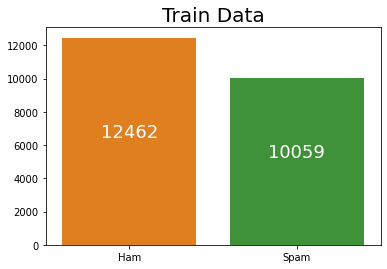

In [ ]:
data_balance = {'labels': ['Ham', 'Spam'],
       'count': [len(y_train_full[y_train_full==0]), len(y_train_full[y_train_full==1])]}
ax = sns.barplot(data=data_balance, x='labels', y='count',palette="Paired_r")
autolabel(ax.patches, "Train Data", labels=data_balance['count'], height_factor=0.5)

### 2.3 Class Balance: Test Data

In [ ]:
6138/(6138+4955)

0.5533219147209952

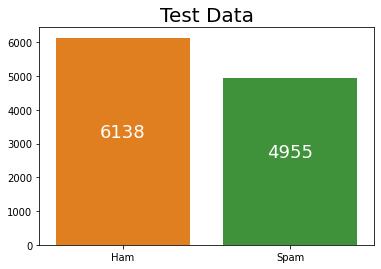

In [ ]:
data_balance = {'labels': ['Ham', 'Spam'],
       'count': [len(y_test_full[y_test_full==0]), len(y_test_full[y_test_full==1])]}
ax = sns.barplot(data=data_balance, x='labels', y='count',palette="Paired_r")
autolabel(ax.patches, "Test Data", labels=data_balance['count'], height_factor=0.5)

## 3. Check for Feature Importance

### 3.1 Preparation

In [ ]:
features = X_train_v.columns

In [ ]:
# Define Feature Importance Function
def base_model_ev(model, X_test, y_test, features, type):
  
  # Print Accuracy Score
  print("--- Model Accuracy Score ---\n{0}\n\n".format(metrics.accuracy_score(y_test, model.predict(X_test))))
  
  # Print Feature Importance Table
  df = pd.DataFrame(columns = ['features', 'importance'])
  df['features'] = features
  if(type == 'lr'):
    df['importance'] = model.coef_[0].tolist()
  elif(type == 'rf'):
    df['importance'] = model.feature_importances_.tolist()
  else:
    print("Please Input Acceptable Model Types")
    return 0
  df = df.sort_values('importance', ascending = False)
  print("--- Feature Importance Table ---\n{0}\n\n".format(df))

  # Plot Feature Importance Bar Chart
  print("--- Feature Importance BarChart ---\n".format(df))
  ax = df['importance'].plot.bar(figsize=(8,8),title='Feature Importance Score')
  ax.set_xticks(range(len(df['features'])))
  ax.set_xticklabels(df['features'])
  ax.axhline(y=0.0, color='black', linestyle='-', linewidth=2)

### 3.2 Train Logistic Regression Base Model

--- Model Accuracy Score ---
0.7568737041377446


--- Feature Importance Table ---
                      features  importance
5                    url_count    5.586698
23       lower_char_percentage    0.635590
16                dollar_count    0.303876
25            colon_percentage    0.241742
17           exclamation_count    0.076339
12     single_digit_word_count    0.071158
13              question_count    0.070904
8           capital_word_count    0.065087
21           dollar_percentage    0.062914
6     consec_exclamation_count    0.053352
1             upper_char_count    0.040175
26               at_percentage    0.036114
11    single_letter_word_count    0.030844
18                      length    0.019656
20      exclamation_percentage    0.006958
7        consec_question_count    0.004474
2             lower_char_count   -0.016226
3           special_char_count   -0.022333
4   capital_char_max_adj_count   -0.032989
15                    at_count   -0.124008
9       all_ca

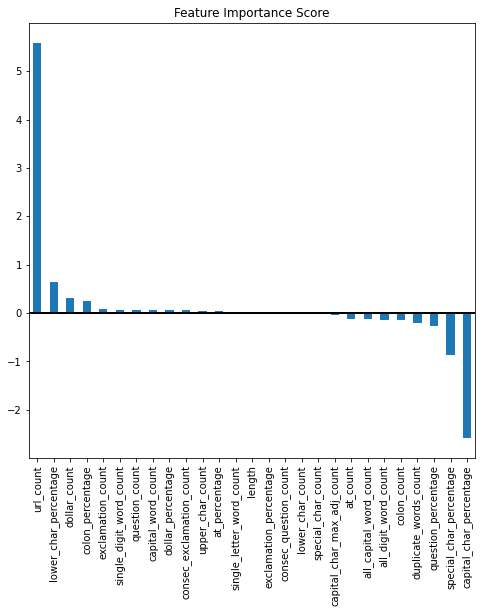

In [ ]:
model = LogisticRegression(solver='lbfgs', max_iter=10000) # needed to increase max_iter to reach convergence
model.fit(X_train_v,  y_train_full)
base_model_ev(model, X_test_v, y_test_full, features, 'lr')

### 3.3 Train Random Forest Base Model

--- Model Accuracy Score ---
0.8856035337600289


--- Feature Importance Table ---
                      features  importance
18                      length    0.082075
2             lower_char_count    0.082042
10        all_digit_word_count    0.079497
23       lower_char_percentage    0.074559
22     special_char_percentage    0.067112
20      exclamation_percentage    0.060596
17           exclamation_count    0.060051
0        duplicate_words_count    0.059950
3           special_char_count    0.054999
25            colon_percentage    0.039723
8           capital_word_count    0.038670
14                 colon_count    0.038095
11    single_letter_word_count    0.038084
1             upper_char_count    0.036536
19     capital_char_percentage    0.026351
4   capital_char_max_adj_count    0.025438
12     single_digit_word_count    0.023508
24         question_percentage    0.020383
21           dollar_percentage    0.017119
26               at_percentage    0.015437
16            

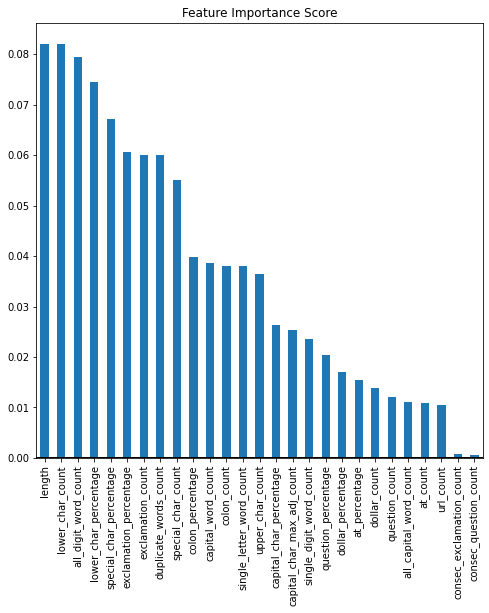

In [ ]:
model = RandomForestClassifier()
model.fit(X_train_v,  y_train_full)
base_model_ev(model, X_test_v, y_test_full, features, 'rf')

## 4. Feature Comparison BarChart

In [ ]:
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10), (ax11, ax12, ax13, ax14, ax15), (ax16, ax17, ax18, ax19, ax20), (ax21, ax22, ax23, ax24, ax25), (ax26, ax27, ax28, ax29, ax30)) = plt.subplots(6, 5, figsize=(50, 30))
plots = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20, ax21, ax22, ax23, ax24, ax25, ax26, ax27]

# Prepare Datasets
df_positive = df_train_full[df_train_full.iloc[:,-1]==1]
df_negative = df_train_full[df_train_full.iloc[:,-1]==0]
df_positive = df_positive.drop(['text', 'cleaned_text', 'cleaned_text_full', 'spam'], axis=1)
df_negative = df_negative.drop(['text', 'cleaned_text', 'cleaned_text_full', 'spam'], axis=1)

# Downsampling
if(len(df_positive) > len(df_negative)):
  df_positive = df_positive.sample(len(df_negative))
elif(len(df_positive) > len(df_negative)):
  df_negative = df_negative.sample(len(df_positive))

# Plot BarChart
fig.suptitle('Feature Comparison BarChart', fontsize=30)

for i in range(len(plots)):
  # Get Data
  df_1 = df_positive.iloc[:,i]
  df_2 = df_negative.iloc[:,i]
  colname = df_positive.columns[i]

  # Handle Percentage Data
  if("percentage" in colname):
    df_1 = df_1 * 100
    df_2 = df_2 * 100

  # Set Bin Range
  df_1_bin_max = math.ceil(np.percentile(df_1, 99)) # Use 99% to prevent outlier from skewing the graph
  df_1_bin_min = max(math.ceil(min(df_1)), 1)
  df_2_bin_max = math.ceil(np.percentile(df_2, 99))
  df_2_bin_min = max(math.ceil(min(df_2)), 1)

  # Set Bin Width
  binwidth_1 = max(math.ceil((df_1_bin_max - df_1_bin_min)/50), 1)
  binwidth_2 = max(math.ceil((df_2_bin_max - df_2_bin_min)/50),1)
  
  # Plot Graphs
  plots[i].hist(df_1, density=True, bins=range(df_1_bin_min, df_1_bin_max + binwidth_1, binwidth_1), histtype='bar', stacked=True, alpha=0.45)
  plots[i].hist(df_2, density=True, bins=range(df_2_bin_min, df_2_bin_max + binwidth_2, binwidth_2), histtype='bar', stacked=True, alpha=0.45)
  plots[i].set_title(colname, fontsize=20)

for ax in fig.get_axes():
    ax.label_outer()

In [ ]:
# Code for Checking Individual BarChart
# x = spam.length
# y = nonspam_balanced.length
# fig, ax = plt.subplots()

# sns.distplot(x, bins=range(1, 3000, 25), ax=ax, kde=False, label = 'spam' )
# sns.distplot(y, bins=range(1, 3000, 25), ax=ax, kde=False, label = 'non-spam')
# ax.set_xlim([0, 1750])

# ax.legend()

## 5. Compare WordCloud

In [ ]:
def spam_text_for_cloud(label):
    text = ' '.join(list(df_train_full[df_train_full['spam'] == label]['cleaned_text']))
    return text

for label in [0, 1]:
    wordcloud = WordCloud(background_color="white").generate(spam_text_for_cloud(label))

    plt.figure(figsize=(16, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(str(['Non-Spam' if label == 0 else 'Spam'][0] ) + ' Wordcloud', fontsize=20)
    plt.show()

    plt.savefig('wc.png', dpi=300)

## 6. Check Data Separability with PCA 2D

In [ ]:
pca = PCA(n_components = 2)
principalComponents  = pca.fit_transform(X_train_tfidf)
principalDf = pd.DataFrame(data = principalComponents , columns = ['PC1', 'PC2'])
finalDf = pd.concat([principalDf, y_train], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA for TF-IDF', fontsize = 20)

targets = [0, 1]
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['spam'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50
               , alpha = 0.2)
ax.legend(targets)
ax.grid()
plt.show()

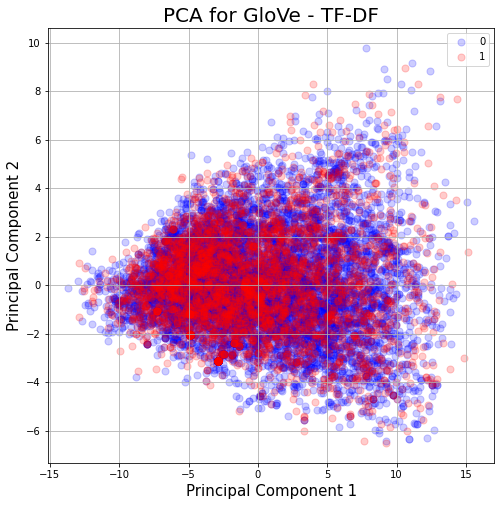

In [ ]:
pca = PCA(n_components = 2)
principalComponents  = pca.fit_transform(X_train_tfidf_glove)
principalDf = pd.DataFrame(data = principalComponents , columns = ['PC1', 'PC2'])
finalDf = pd.concat([principalDf, y_train], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA for GloVe - TF-DF', fontsize = 20)

targets = [0, 1]
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['spam'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50
               , alpha = 0.2)
ax.legend(targets)
ax.grid()
plt.show()

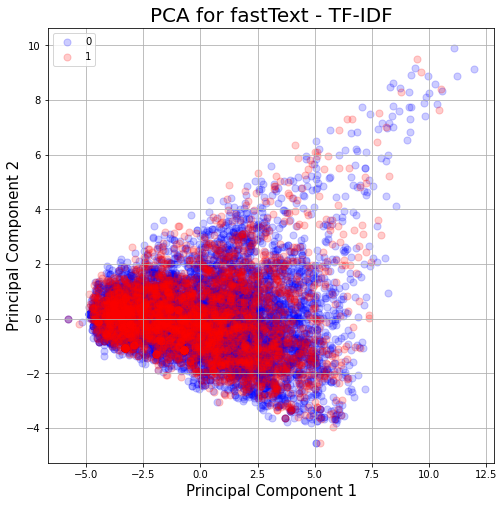

In [ ]:
pca = PCA(n_components = 3)
principalComponents  = pca.fit_transform(X_train_tfidf_cc)
principalDf = pd.DataFrame(data = principalComponents , columns = ['PC1', 'PC2', 'PC3'])
finalDf = pd.concat([principalDf, y_train], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA for fastText - TF-IDF', fontsize = 20)

targets = [0, 1]
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['spam'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50
               , alpha = 0.2)
ax.legend(targets)
ax.grid()
plt.show()

## 7. Check Data Separability with PCA 3D

In [ ]:
pca = PCA(n_components=3)
components = pca.fit_transform(X_train_tfidf)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y_train,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={0: 'Ham', 1: 'Spam'},
    opacity=0.5,
)
fig.show()

In [ ]:
pca = PCA(n_components=3)
components = pca.fit_transform(X_train_tfidf_glove)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y_train,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={0: 'Ham', 1: 'Spam'},
    opacity=0.5,
)
fig.show()

In [ ]:
pca = PCA(n_components=3)
components = pca.fit_transform(X_train_tfidf_cc)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y_train,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={0: 'Ham', 1: 'Spam'},
    opacity=0.5,
)
fig.show()